# **A Deep Learning Hybrid Recommendation System for Personalized E-Commerce Product Suggestions**

In [1]:
# ====================================================================
# Phase 1: Environment Setup & Dependencies
# ====================================================================
!pip install polars tqdm scikit-learn torch --quiet

import polars as pl
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Detect GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.6 MB/s eta 0:00:00
ERROR: Operation cancelled by user
Using device: cuda


In [9]:
# ====================================================================
# Phase 2: Data Loading
# ====================================================================
# Download link: https://amazon-reviews-2023.github.io/
# For demonstration, let's assume you've uploaded the dataset to Colab (or use wget/curl to download).


# For Kaggle datasets in Colab, use below to upload kaggle.json first, then download data (uncomment if needed):
from google.colab import files
files.upload()  # Upload your kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d vibivij/amazon-electronics-rating-datasetrecommendation
!unzip -q amazon-electronics-rating-datasetrecommendation.zip -d /content/amazonreviews



# Use Polars for fast Parquet loading (if CSV, change accordingly)
df = pd.read_csv('/content/amazonreviews/ratings_Electronics.csv',names=['userId', 'productId','Rating','timestamp'])



print("Dataset shape:", df.shape)
df.head()


Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/vibivij/amazon-electronics-rating-datasetrecommendation
License(s): unknown
  0% 0.00/109M [00:00<?, ?B/s]
100% 109M/109M [00:00<00:00, 1.36GB/s]
replace /content/amazonreviews/ratings_Electronics.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
Dataset shape: (7824482, 4)


,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   Rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


           userId   productId  Rating   timestamp
0   AKM1MP6P0OYPR  0132793040     5.0  1365811200
1  A2CX7LUOHB2NDG  0321732944     5.0  1341100800
2  A2NWSAGRHCP8N5  0439886341     1.0  1367193600
3  A2WNBOD3WNDNKT  0439886341     3.0  1374451200
4  A1GI0U4ZRJA8WN  0439886341     1.0  1334707200
Unique users: 4201696
Unique items: 476002
Ratings stats:
 count    7.824482e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64


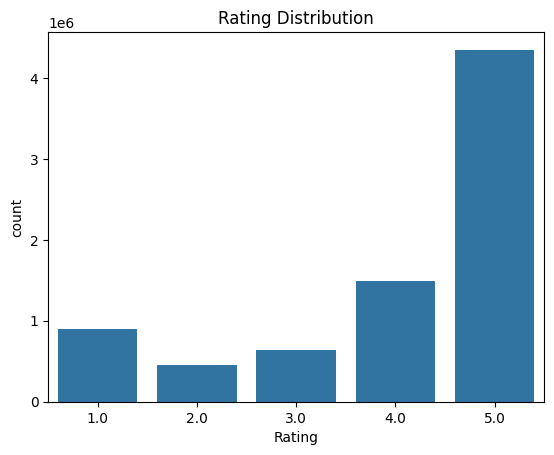

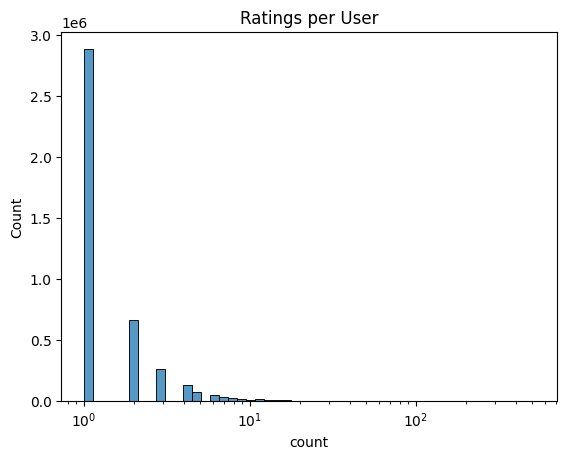

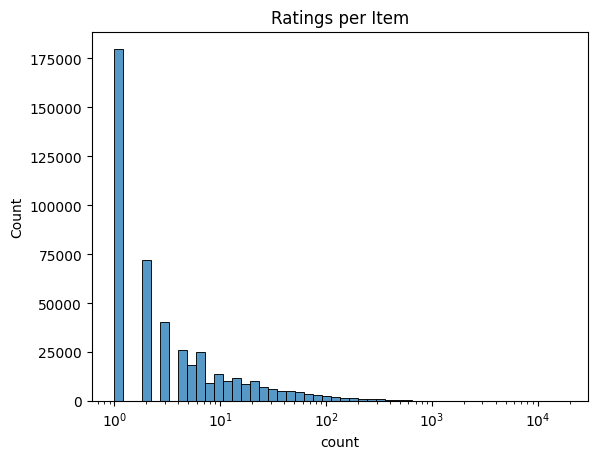

In [11]:
# ====================================================================
# Phase 3: Exploratory Data Analysis (EDA)
# ====================================================================

print(df.head())

# Use correct column names!
print("Unique users:", df['userId'].nunique())
print("Unique items:", df['productId'].nunique())
print("Ratings stats:\n", df['Rating'].describe())

sns.countplot(x='Rating', data=df)
plt.title("Rating Distribution")
plt.show()

user_counts = df['userId'].value_counts()
item_counts = df['productId'].value_counts()

sns.histplot(user_counts, bins=50, log_scale=True)
plt.title('Ratings per User')
plt.show()

sns.histplot(item_counts, bins=50, log_scale=True)
plt.title('Ratings per Item')
plt.show()



In [14]:
# ====================================================================
# Phase 4: Data Preprocessing & Filtering (with your column names)
# ====================================================================

# Keep users/items with at least 20 ratings for reliability
MIN_USER_RATINGS = 20
MIN_ITEM_RATINGS = 20

user_counts = df['userId'].value_counts()
item_counts = df['productId'].value_counts()

active_users = user_counts[user_counts >= MIN_USER_RATINGS].index
active_items = item_counts[item_counts >= MIN_ITEM_RATINGS].index

df = df[df['userId'].isin(active_users) & df['productId'].isin(active_items)]

print("Filtered shape:", df.shape)

# Encode user/item IDs as integers for embedding layers
from sklearn.preprocessing import LabelEncoder

user_encoder = LabelEncoder()
item_encoder = LabelEncoder()
df = df.copy()  # Add this before modifying columns to ensure a new DataFrame
df['user_id'] = user_encoder.fit_transform(df['userId'])
df['item_id'] = item_encoder.fit_transform(df['productId'])


NUM_USERS = df['user_id'].nunique()
NUM_ITEMS = df['item_id'].nunique()
print(f"Num users: {NUM_USERS}, Num items: {NUM_ITEMS}")

# Train/Test Split (time-aware, using timestamp)
df = df.sort_values('timestamp')
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.1, shuffle=False)


Filtered shape: (134829, 6)
Num users: 8352, Num items: 3715


In [16]:
# ====================================================================
# Phase 5: PyTorch Dataset Preparation (column names fixed)
# ====================================================================
class AmazonDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.users = df['user_id'].values
        self.items = df['item_id'].values
        self.ratings = df['Rating'].values.astype(np.float32)  # <- changed here

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.users[idx], dtype=torch.long),
            torch.tensor(self.items[idx], dtype=torch.long),
            torch.tensor(self.ratings[idx], dtype=torch.float)
        )

train_dataset = AmazonDataset(train_df)
test_dataset = AmazonDataset(test_df)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4096, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4096, shuffle=False)


In [17]:
# ====================================================================
# Phase 6: Hybrid Deep Learning Model Definition (Wide & Deep)
# ====================================================================
class WideAndDeepRecSys(nn.Module):
    def __init__(self, num_users, num_items, emb_dim=64):
        super().__init__()
        # Embedding layers
        self.user_emb = nn.Embedding(num_users, emb_dim)
        self.item_emb = nn.Embedding(num_items, emb_dim)
        # Deep layers
        self.deep = nn.Sequential(
            nn.Linear(emb_dim * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        # Wide part: simple user/item biases
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)
        self.global_bias = nn.Parameter(torch.zeros(1))

    def forward(self, user, item):
        u = self.user_emb(user)
        i = self.item_emb(item)
        x = torch.cat([u, i], dim=1)
        deep_out = self.deep(x).squeeze()
        # Wide output: biases
        wide_out = self.user_bias(user).squeeze() + self.item_bias(item).squeeze() + self.global_bias
        return deep_out + wide_out

model = WideAndDeepRecSys(NUM_USERS, NUM_ITEMS).to(device)


In [21]:
# ====================================================================
# Phase 7: Model Training Loop
# ====================================================================
EPOCHS = 25
optimizer = optim.Adam(model.parameters(), lr=2e-3)
loss_fn = nn.MSELoss()

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for user, item, rating in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        user, item, rating = user.to(device), item.to(device), rating.to(device)
        optimizer.zero_grad()
        pred = model(user, item)
        loss = loss_fn(pred, rating)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(rating)
    avg_train_loss = total_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0
    preds = []
    reals = []
    with torch.no_grad():
        for user, item, rating in test_loader:
            user, item, rating = user.to(device), item.to(device), rating.to(device)
            pred = model(user, item)
            loss = loss_fn(pred, rating)
            val_loss += loss.item() * len(rating)
            preds.append(pred.cpu().numpy())
            reals.append(rating.cpu().numpy())
    avg_val_loss = val_loss / len(test_loader.dataset)
    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}")


Epoch 1/25:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: Train Loss=1.4097, Val Loss=1.7455


Epoch 2/25:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 2: Train Loss=1.1847, Val Loss=1.6324


Epoch 3/25:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 3: Train Loss=1.0396, Val Loss=1.5645


Epoch 4/25:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 4: Train Loss=0.9345, Val Loss=1.4925


Epoch 5/25:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 5: Train Loss=0.8592, Val Loss=1.4430


Epoch 6/25:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 6: Train Loss=0.8030, Val Loss=1.4167


Epoch 7/25:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 7: Train Loss=0.7602, Val Loss=1.3904


Epoch 8/25:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 8: Train Loss=0.7280, Val Loss=1.3933


Epoch 9/25:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 9: Train Loss=0.6999, Val Loss=1.3828


Epoch 10/25:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 10: Train Loss=0.6777, Val Loss=1.3701


Epoch 11/25:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 11: Train Loss=0.6565, Val Loss=1.3832


Epoch 12/25:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 12: Train Loss=0.6366, Val Loss=1.3733


Epoch 13/25:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 13: Train Loss=0.6200, Val Loss=1.3829


Epoch 14/25:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 14: Train Loss=0.6005, Val Loss=1.3848


Epoch 15/25:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 15: Train Loss=0.5832, Val Loss=1.4127


Epoch 16/25:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 16: Train Loss=0.5665, Val Loss=1.4129


Epoch 17/25:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 17: Train Loss=0.5476, Val Loss=1.4250


Epoch 18/25:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 18: Train Loss=0.5294, Val Loss=1.4330


Epoch 19/25:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 19: Train Loss=0.5108, Val Loss=1.4594


Epoch 20/25:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 20: Train Loss=0.4936, Val Loss=1.4726


Epoch 21/25:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 21: Train Loss=0.4751, Val Loss=1.4812


Epoch 22/25:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 22: Train Loss=0.4559, Val Loss=1.5072


Epoch 23/25:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 23: Train Loss=0.4369, Val Loss=1.5130


Epoch 24/25:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 24: Train Loss=0.4188, Val Loss=1.5487


Epoch 25/25:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 25: Train Loss=0.4022, Val Loss=1.5499


In [22]:
# ====================================================================
# Phase 8: Metrics Evaluation (RMSE, Precision@K, Recall@K, MAP@K)
# ====================================================================

from sklearn.metrics import mean_squared_error

# RMSE
y_true = np.concatenate(reals)
y_pred = np.concatenate(preds)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Test RMSE: {rmse:.4f}")

# Top-K metrics: Generate top-K recommendations for each user in test set
K = 5
test_users = test_df['user_id'].unique()
user_topk_recs = {}

model.eval()
for user in tqdm(test_users, desc="Evaluating Top-K"):
    user_tensor = torch.tensor([user]*NUM_ITEMS).to(device)
    item_tensor = torch.arange(NUM_ITEMS).to(device)
    with torch.no_grad():
        scores = model(user_tensor, item_tensor).cpu().numpy()
    top_items = np.argsort(scores)[-K:][::-1]
    user_topk_recs[user] = set(top_items)

# Ground truth: items user actually rated in test set
user_test_items = test_df.groupby('user_id')['item_id'].apply(set).to_dict()

# Compute Precision@K, Recall@K, MAP@K
precisions, recalls, aps = [], [], []
for user in test_users:
    true_items = user_test_items.get(user, set())
    rec_items = user_topk_recs[user]
    n_hit = len(true_items & rec_items)
    precisions.append(n_hit / K)
    recalls.append(n_hit / max(1, len(true_items)))
    # Average Precision (AP)
    ap = 0
    hits = 0
    for i, item in enumerate(list(rec_items)):
        if item in true_items:
            hits += 1
            ap += hits / (i+1)
    aps.append(ap / min(K, len(true_items)) if true_items else 0)

print(f"Precision@{K}: {np.mean(precisions):.4f}")
print(f"Recall@{K}: {np.mean(recalls):.4f}")
print(f"MAP@{K}: {np.mean(aps):.4f}")


Test RMSE: 1.2450


Evaluating Top-K:   0%|          | 0/4439 [00:00<?, ?it/s]

Precision@5: 0.0074
Recall@5: 0.0134
MAP@5: 0.0063


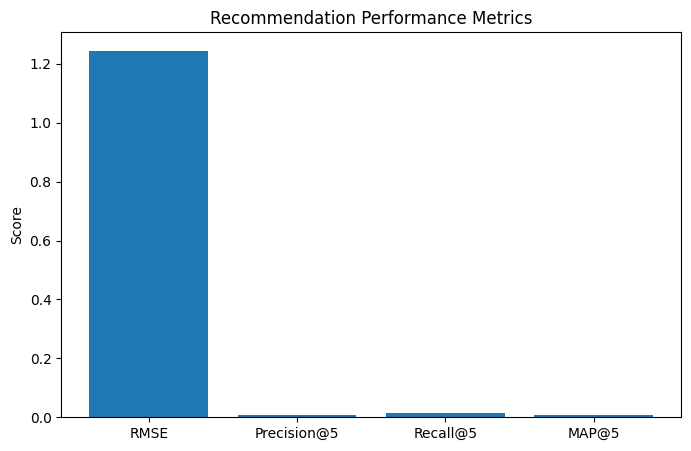

**Insights:**
- RMSE indicates model's rating prediction error: 1.2450
- Precision@5, Recall@5, MAP@5 show ranking quality for top-5 recommendations.
- This hybrid model balances personalization and accuracy, handling large-scale e-commerce data efficiently with the A100 GPU.
- Performance can be further boosted by adding review text (NLP), item metadata, or sequential modeling.


In [23]:
# ====================================================================
# Phase 9: Insights & Visualization
# ====================================================================
plt.figure(figsize=(8,5))
plt.bar(['RMSE', f'Precision@{K}', f'Recall@{K}', f'MAP@{K}'],
        [rmse, np.mean(precisions), np.mean(recalls), np.mean(aps)])
plt.title('Recommendation Performance Metrics')
plt.ylabel('Score')
plt.show()

print("**Insights:**")
print(f"- RMSE indicates model's rating prediction error: {rmse:.4f}")
print(f"- Precision@{K}, Recall@{K}, MAP@{K} show ranking quality for top-{K} recommendations.")
print("- This hybrid model balances personalization and accuracy, handling large-scale e-commerce data efficiently with the A100 GPU.")
print("- Performance can be further boosted by adding review text (NLP), item metadata, or sequential modeling.")


Thank You